## Import Packages

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns
import time

import imageio

import IPython
from IPython.display import Image

import sys, subprocess
import time

from State import State
from Movement_evaluation import evaluate_by_gravity
import numpy as np
import random
import time
from Ball import Ball
from Config import *
from Game import Game

In [2]:
sns.set_context("talk")

# Random Agent

In [40]:
class Random_Agent(object):
        
    def get_action(self, state):
        
        return random.randint(0, int(state.screen_x))

def play_one_episode(game, agent, max_step = None, plot = False):
    is_finish = False
    current_state = game.init_state()
    reward_recorder = []
    step = 1

    while not is_finish:
        action = agent.get_action(current_state)
        print(action)
        next_state, reward, is_finish = game.next_step(action, verbose = False)
        if plot:
            next_state.plot_state()
        reward_recorder.append(reward)
        current_state = next_state
        step += 1
        if max_step and step >= max_step:
            break
    
    return reward_recorder[-1], reward_recorder, game.current_reward

## test random agent

In [41]:
random_agent = Random_Agent()

final_rewards = [] # sum of the score at each step
scores = []

start_time = time.time()
for i in range(20):
    game = Game(screen_x, screen_y, end_line, balls_setting, max_random_ball_level)
    R, _, score = play_one_episode(game, random_agent, max_step=100)
    print(i, "\t th episode: ", R)
    final_rewards.append(R)
    scores.append(score)
end_time = time.time()

print( (end_time - start_time)/ 60 )

14
27
33
251
98
4
195
16
215
140
106
225
21
137
121
133
231
35
160
175
169
2
203
41
76
222
181
119
204
251
52
250
89
80
148
1
164
153
122
56
29
108
56
71
26
30
157
61
93
140
111
227
209
225
78
235
64
232
71
30
155
171
179
232
88
166
171
87
19
44
226
97
80
48
182
222
92
44
10
186
232
0 	 th episode:  264
128
58
41
92
160
206
212
244
60
85
135
0
30
183
205
251
11
2
40
11
58
224
219
48
28
139
37
190
245
145
126
214
191
122
117
156
78
138
88
156
132
163
167
4
159
218
147
174
99
216
208
169
102
86
234
58
1
135
115
245
37
49
145
65
123
228
232
153
213
170
200
160
83
116
171
174
56
9
3
104
137
136
206
70
197
32
105
64
195
29
190
173
68
30
186
12
12
112
78
1 	 th episode:  306
76
240
28
68
54
204
135
141
108
143
13
237
124
86
182
34
64
117
77
170
175
70
62
198
189
173
188
97
152
13
12
57
76
41
53
190
163
5
120
251
187
194
136
103
2 	 th episode:  147
217
41
78
139
155
194
137
2
199
146
85
92
37
128
215
48
172
221
26
199
28
124
67
106
245
150
67
76
153
40
51
180
100
131
242
70
198
55
158
111
24

(array([1., 2., 0., 1., 0., 3., 5., 3., 1., 4.]),
 array([147., 163., 179., 195., 211., 227., 243., 259., 275., 291., 307.]),
 <a list of 10 Patch objects>)

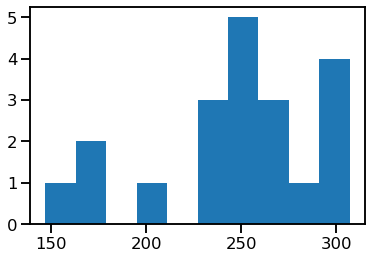

In [42]:
plt.hist(final_rewards)

In [44]:
print(sum(final_rewards) / 20)

246.15


# Logistic Regression + Cross Entropy Search

In [4]:
def sigmoid(x):
    """
    x: float
    """
    return 1.0 / (1.0 + np.exp(-x))


def logistic_regression(s, theta):
    """
    s: State
    theta: np.array, with the same dimension as the vectorized state
    """
    left2right_proportion = sigmoid(np.dot(s.vectorize(), np.transpose(theta)))
    return left2right_proportion


def draw_action(s, theta):
    return int(s.screen_x * logistic_regression(s, theta))

In [5]:
class LogisticRegression:

    def __init__(self, game):        
        self.num_params = len(game.current_state.vectorize())

    def __call__(self, state, theta):
        return draw_action(state, theta)
    

class LogisticRegressionAgent(object):
    
    def __init__(self, theta):
        self.theta = theta
    
    def get_action(self, state):
        return draw_action(state, self.theta)

In [6]:
class ObjectiveFunction:

    def __init__(self, game, policy, num_episodes=1, max_time_steps=float('inf'), minimization_solver=True):
        self.ndim = policy.num_params  # Number of dimensions of the parameter (weights) space
        self.game = game
        self.policy = policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0

        
    def eval(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        """Evaluate a policy"""

        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        average_total_rewards = 0

        for i_episode in range(num_episodes):

            total_rewards = 0.
            state = self.game.init_state()
            self.game.is_finish = False
            for t in range(max_time_steps):
                if render:
                    self.game.current_state.plot_state(is_plt=True)

                action = self.policy(state, policy_params)
                
                state, reward, is_finish = self.game.next_step(action, verbose = False)
                total_rewards = reward
                
                if is_finish:
                    break

            average_total_rewards += float(total_rewards) / num_episodes

            if render:
                print("Test Episode {0}: Total Reward = {1}".format(i_episode, total_rewards))

        if self.minimization_solver:
            average_total_rewards *= -1.

        return average_total_rewards   # Optimizers do minimization by default...

    
    def __call__(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        return self.eval(policy_params, num_episodes, max_time_steps, render)

In [29]:
game = Game(screen_x, screen_y, end_line, balls_setting, max_random_ball_level)

nn_policy = LogisticRegression(game)

objective_function = ObjectiveFunction(game=game,
                                       policy=nn_policy,
                                       num_episodes=1,
                                       max_time_steps=100)

In [30]:
init_mean_array = np.random.random(nn_policy.num_params) - 0.5
init_var_array = np.ones(nn_policy.num_params)

In [11]:
def cem_uncorrelated(objective_function,
                     mean_array,
                     var_array,
                     max_iterations=500,
                     sample_size=30,
                     elite_frac=0.2,
                     print_every=10,
                     success_score=float("inf"),
                     num_evals_for_stop=None,
                     hist_dict=None):
    """Cross-entropy method.
    Params
    ======
        objective_function (function): the function to maximize
        mean_array (array of floats): the initial proposal distribution (mean vector)
        var_array (array of floats): the initial proposal distribution (variance vector)
        max_iterations (int): number of training iterations
        sample_size (int): size of population at each iteration
        elite_frac (float): rate of top performers to use in update with elite_frac ∈ ]0;1]
        print_every (int): how often to print average score
        hist_dict (dict): logs
    """
    assert 0. < elite_frac <= 1.
    n_elite = math.ceil(sample_size * elite_frac)
    optimal_score = 100
    theta = mean_array
    ### BEGIN SOLUTION ###
    for iteration_index in range(0, max_iterations):
        # SAMPLE A NEW POPULATION OF SOLUTIONS (THETA VECTORS) ################
        theta_array = np.random.multivariate_normal(mean=mean_array, cov=np.diag(var_array), size=(sample_size))
        # EVALUATE SAMPLES AND EXTRACT THE BEST ONES ("ELITE") ################
        score_array = np.array([objective_function(theta) for theta in theta_array])
        sorted_indices_array = score_array.argsort()             # Sort from the lower score to the higher one
        elite_indices_array = sorted_indices_array[:n_elite]     # Recall: we *minimize* the objective function thus we take the samples that are at the begining of the sorted_indices
        elite_theta_array = theta_array[elite_indices_array]
        # FIT THE NORMAL DISTRIBUTION ON THE ELITE POPULATION #################
        mean_array = elite_theta_array.mean(axis=0)
        var_array = elite_theta_array.var(axis=0)
        score = objective_function(mean_array)
        # PRINT STATUS ########################################################
        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))
            print("mean array: ", mean_array)
            print("var array: ", var_array)
        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + mean_array.tolist() + var_array.tolist()
        # STOPING CRITERIA ####################################################
        if num_evals_for_stop is not None:
            score = objective_function(mean_array, num_episodes=num_evals_for_stop)
        # `num_evals_for_stop = None` may be used to fasten computations but it introduce bias...
        
        if score < optimal_score:
            optimal_score = score
            np.save( "theta.npy", mean_array )
            theta= mean_array
            
        if score <= success_score:
            break
            
        if np.max(np.abs(var_array)) < 10 ** -2:
            break
    ### END SOLUTION ###
    return theta

In [31]:
hist_dict = {}

init_mean_array = np.random.random(nn_policy.num_params) - 0.5
init_var_array = np.ones(nn_policy.num_params)

theta = cem_uncorrelated(objective_function=objective_function,
                         mean_array=init_mean_array,
                         var_array=init_var_array,
                         max_iterations=50,
                         sample_size=30,
                         elite_frac=0.33,
                         print_every=1,
                         success_score=-800,
                         num_evals_for_stop=None,
                         hist_dict=hist_dict)

Iteration 0	Score -207.0
mean array:  [ 0.20158511  0.48675348 -0.23061528  0.04205472  0.41764354  0.07786917
 -0.52566151  0.49421288 -0.31533828 -0.5283371   0.21968514  0.14818638
 -0.3198222   0.23501713 -0.17724756 -0.05899386 -0.61824238  0.24608377
 -0.37044267 -0.07135928  0.53871031 -0.37876214  0.11788056  0.27351177
  0.06980565 -0.09612379  0.48413471  0.50447466  0.48612822  0.19733702
  0.21471919]
var array:  [1.57747032 0.29852332 0.66418359 0.27200839 1.51638368 0.91513083
 0.92651528 0.4884685  1.21874189 1.59231642 0.78016514 0.52407751
 0.89220677 0.5862579  1.1238909  1.989963   0.98285845 0.5903195
 1.71542101 0.97522311 1.31756668 0.45808575 0.67168488 0.49695221
 0.43855067 0.44733879 0.96435436 1.46366509 1.19124325 1.3182889
 0.45593446]
Iteration 1	Score -213.0
mean array:  [ 0.31171065  0.35942634 -0.52073635 -0.28316591  0.30047047 -0.02215685
 -0.48134229  0.56430085  0.31858892 -0.88009055  0.3497602  -0.20300225
 -0.15693529  0.53475218 -1.25501793  0.3

Iteration 11	Score -267.0
mean array:  [-0.34254664 -0.25448064 -0.61344414 -0.73062226  0.72625314 -0.10586848
 -0.5200789   0.07900738  0.08188785  0.41662534  0.29284372  0.14469767
 -0.43408069  0.71686661 -1.44587355 -0.59347169 -1.02183894 -0.7600033
  0.68836993 -0.2680972   0.05056875 -0.41606416 -0.20747115  0.81729313
 -0.07002256  0.67385567  1.28229601  1.00843886 -0.05785791 -1.40859341
  0.69460156]
var array:  [0.39919899 0.00412056 0.00950572 0.02151507 0.0074284  0.07376085
 0.03348918 0.16749682 0.01903771 0.19045904 0.07140529 0.02841354
 0.76242028 1.21220092 0.04376387 1.4265722  0.00860639 0.18451978
 0.17875704 0.00554686 0.07716687 0.08777408 0.21110629 0.08729811
 0.02602009 0.03660931 0.01187447 0.01873426 0.73738213 0.76523829
 0.00925601]
Iteration 12	Score -190.0
mean array:  [-0.66763443 -0.25535191 -0.62087838 -0.62775463  0.70824038 -0.12259711
 -0.51424827  0.18350718  0.12617215  0.50552085  0.28499369  0.17513653
 -0.48352311  1.06044222 -1.47981803 -

Iteration 21	Score -314.0
mean array:  [-0.57758324 -0.25469115 -0.64183671 -0.8687847   0.76977699  0.09399981
 -0.53210281  0.51323124  0.38424385  0.66935863  0.30879381  0.13294444
  0.29041346  1.31918083 -1.2844764  -1.39851989 -1.04491475 -0.62010097
  1.00450562 -0.2976436  -0.05912535 -0.12708147 -0.40894926  0.54848857
 -0.17278053  0.89597805  1.17685508  1.03028987  0.5966188  -2.19744927
  0.75525526]
var array:  [5.02282196e-03 2.77689242e-03 7.86448298e-04 1.75328675e-02
 2.46598268e-03 3.10045873e-04 5.19106468e-04 2.35426200e-03
 2.13800128e-03 3.21009546e-03 8.28121196e-03 4.75097512e-03
 5.24816497e-02 1.25450906e-01 2.85977065e-04 3.69976806e-02
 1.82460000e-03 2.07843339e-03 1.75627099e-02 9.91396475e-05
 1.98667874e-03 3.40194133e-03 2.72773419e-02 3.07042047e-02
 8.79278931e-04 1.37024418e-02 2.39682479e-04 1.98671350e-03
 6.22539690e-01 1.63331296e-01 5.56567546e-03]
Iteration 22	Score -284.0
mean array:  [-0.57456292 -0.24484715 -0.64735217 -0.93233175  0.75008

Iteration 31	Score -251.0
mean array:  [-0.54982478 -0.21768955 -0.64133589 -0.84745573  0.76247928  0.06952518
 -0.53770322  0.50270842  0.31471452  0.70759552  0.34242758  0.15038687
  0.21851362  1.2534428  -1.29043106 -1.2831072  -1.09767073 -0.58069422
  1.0549124  -0.29487276 -0.03373435 -0.04409539 -0.38973363  0.65529592
 -0.16345052  0.90603629  1.18340713  0.97596607  1.27015975 -2.33616594
  0.82972359]
var array:  [1.25071350e-04 2.04982766e-04 1.01624019e-04 3.18730648e-04
 1.45799494e-04 1.18931304e-05 9.30107749e-05 2.79172450e-04
 2.75161353e-04 3.61807598e-04 2.70230350e-04 3.86100529e-04
 9.38513095e-03 3.56494304e-03 5.20438940e-06 8.03943240e-03
 1.58043554e-05 1.32091747e-03 4.28636558e-03 4.74968812e-06
 1.44604830e-03 3.33894945e-03 2.00879177e-03 1.27504234e-03
 5.24794723e-05 3.68765290e-04 3.39093275e-06 4.08121710e-04
 5.19663028e-02 4.27983359e-02 5.26160377e-04]
Iteration 32	Score -189.0
mean array:  [-0.54908594 -0.21439393 -0.64156893 -0.85877277  0.76425

Iteration 41	Score -290.0
mean array:  [-0.55870039 -0.22083006 -0.62981716 -0.8545673   0.76423047  0.06738508
 -0.54238746  0.5227421   0.32426037  0.71458508  0.33511058  0.1513694
  0.21245005  1.17257269 -1.29078883 -1.23523747 -1.09888366 -0.54502401
  1.08293402 -0.29509705 -0.06838237 -0.01049157 -0.41218832  0.64566973
 -0.15838922  0.91164412  1.18608777  0.9836731   1.54248446 -2.39189784
  0.841876  ]
var array:  [5.77820900e-06 8.71252362e-06 2.97105823e-05 7.72589849e-06
 3.24121465e-05 2.88955051e-07 1.96906889e-06 5.15955120e-05
 3.30341288e-05 4.32045503e-04 2.50690940e-05 1.69286208e-04
 1.31639662e-04 4.63172296e-03 1.45230369e-07 4.20714986e-03
 1.63655592e-07 2.69134113e-04 8.44238127e-04 5.51847454e-08
 2.54487204e-04 6.74626100e-05 2.59414653e-04 1.12076107e-04
 6.89117646e-05 9.82244529e-06 2.83134574e-07 7.50526730e-05
 1.50316751e-02 9.16109339e-03 3.56362539e-05]
Iteration 42	Score -203.0
mean array:  [-0.55813026 -0.22002866 -0.62948347 -0.8543713   0.764115

In [32]:
np.save( "theta.npy", theta )

Text(0, 0.5, 'Reward')

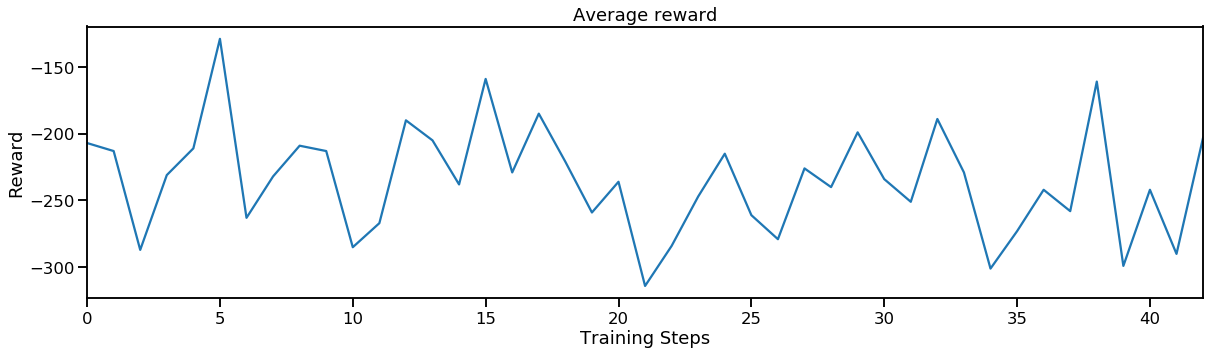

In [33]:
df = pd.DataFrame.from_dict(hist_dict, orient='index')
ax = df[0].plot(title="Average reward", figsize=(20, 5));
plt.xlabel("Training Steps")
plt.ylabel("Reward")

In [34]:
df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-207.0,0.201585,0.486753,-0.230615,0.042055,0.417644,0.077869,-0.525662,0.494213,-0.315338,...,0.458086,0.671685,0.496952,0.438551,0.447339,9.643544e-01,1.463665,1.191243,1.318289,0.455934
1,-213.0,0.311711,0.359426,-0.520736,-0.283166,0.300470,-0.022157,-0.481342,0.564301,0.318589,...,0.366300,0.289949,0.479954,0.538342,0.333788,4.498455e-01,0.504420,0.491820,1.056562,0.647557
2,-287.0,-0.128043,0.168963,-0.755072,-0.305278,0.734676,-0.008425,-0.579871,0.372375,0.441617,...,0.343044,0.291394,0.599734,0.607682,0.386011,2.366737e-01,0.545403,1.294770,1.389847,0.481987
3,-231.0,-0.353961,0.201826,-0.629531,-0.332765,1.438914,-0.154632,-0.611174,0.232412,0.177984,...,0.632038,0.349258,0.350292,0.387739,0.547121,2.874536e-01,0.209387,1.032578,1.890102,0.395348
4,-211.0,-0.278528,-0.039875,-0.660419,-0.408653,1.600450,-0.015659,-0.615000,0.029065,0.136585,...,0.713925,0.286215,0.274534,0.344517,0.439547,2.308066e-01,0.234166,1.198112,2.640231,0.322952
5,-129.0,-0.353504,-0.119948,-0.576981,-0.430591,1.026134,-0.293916,-0.644572,0.021857,0.022826,...,0.354043,0.260664,0.215630,0.311268,0.174671,3.129231e-01,0.153382,1.318872,3.151877,0.134731
6,-263.0,-0.251644,-0.209891,-0.615606,-0.539692,0.806566,-0.326529,-0.790081,-0.065524,0.036865,...,0.181778,0.249578,0.067932,0.234068,0.256503,2.219992e-01,0.110092,1.056537,3.164798,0.023283
7,-232.0,-0.143850,-0.263523,-0.532149,-0.532481,0.717145,-0.432909,-0.336833,0.134558,0.071299,...,0.175008,0.124438,0.073417,0.067648,0.177464,2.836057e-01,0.109734,0.877032,2.764240,0.043838
8,-209.0,-0.195962,-0.250909,-0.495678,-0.588166,0.672266,-0.235843,-0.353525,0.275067,0.146217,...,0.086235,0.134639,0.143911,0.028345,0.112453,4.551481e-02,0.039654,0.420122,1.602605,0.032042
9,-213.0,0.054103,-0.273403,-0.501126,-0.695630,0.637033,-0.408456,-0.540418,0.216611,0.142256,...,0.094672,0.146176,0.116562,0.047069,0.104391,2.095251e-02,0.053277,0.527109,2.820994,0.012586


Text(0.5, 0, 'Training Steps')

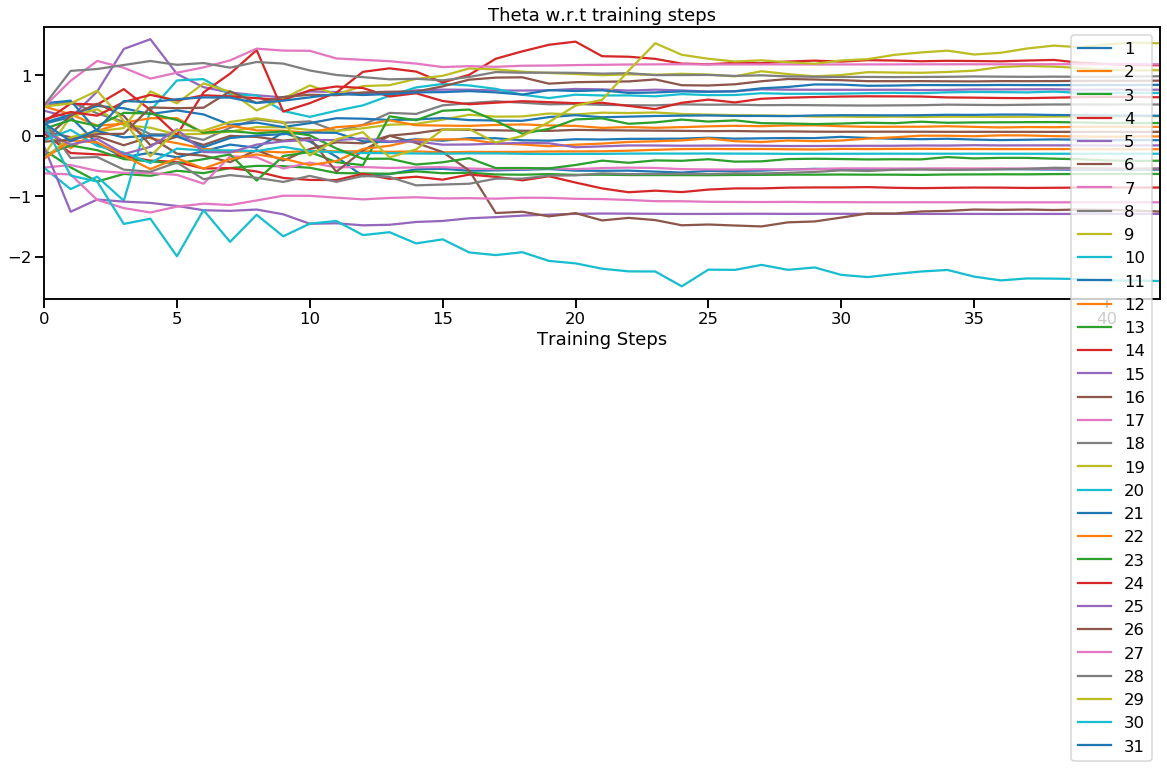

In [35]:
ax = df[list(range(1, 32))].plot(title="Theta w.r.t training steps", figsize=(20, 5));
plt.xlabel("Training Steps")

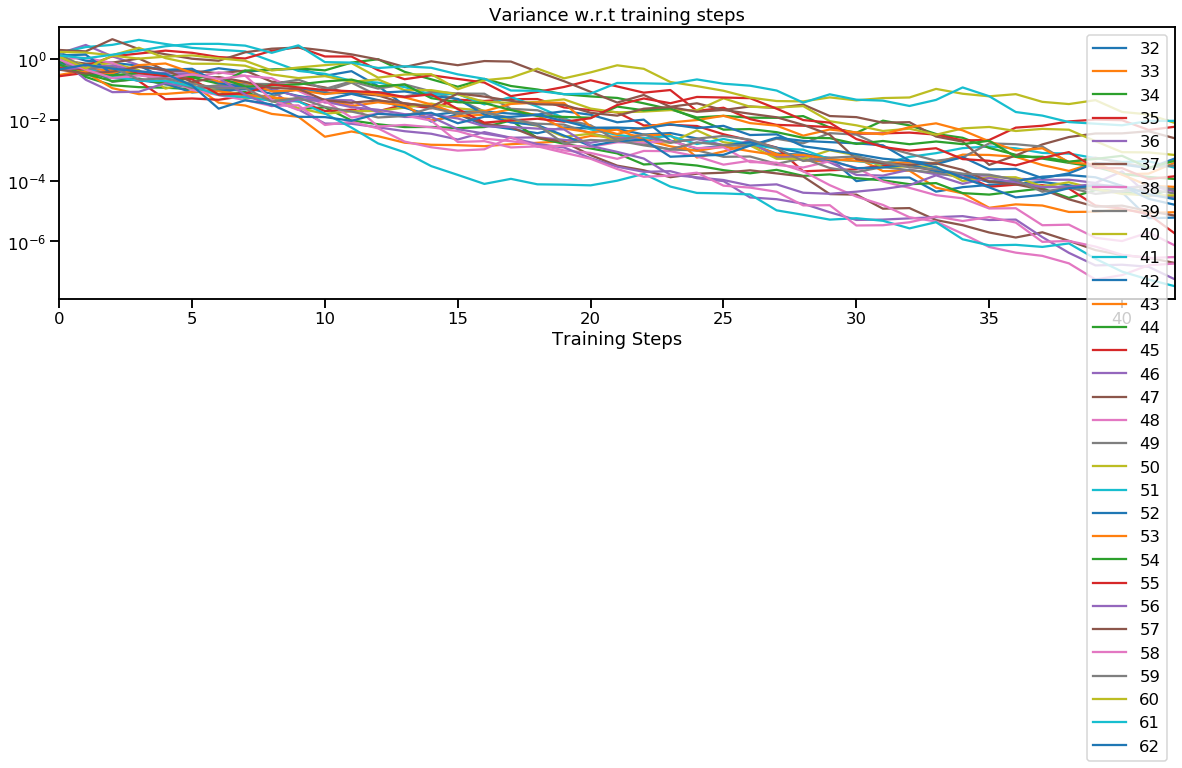

In [36]:
ax = df[list(range(32, 63))].plot(logy=True, title="Variance w.r.t training steps", figsize=(20, 5))
plt.xlabel("Training Steps");

In [87]:
theta = np.array( df[list(range(1, 32))] )

In [37]:
np.load("theta.npy")

array([-0.57758324, -0.25469115, -0.64183671, -0.8687847 ,  0.76977699,
        0.09399981, -0.53210281,  0.51323124,  0.38424385,  0.66935863,
        0.30879381,  0.13294444,  0.29041346,  1.31918083, -1.2844764 ,
       -1.39851989, -1.04491475, -0.62010097,  1.00450562, -0.2976436 ,
       -0.05912535, -0.12708147, -0.40894926,  0.54848857, -0.17278053,
        0.89597805,  1.17685508,  1.03028987,  0.5966188 , -2.19744927,
        0.75525526])

In [45]:
lr_agent = LogisticRegressionAgent(theta)
final_rewards = [] # sum of the score at each step
scores = []

start_time = time.time()
for i in range(20):
    game = Game(screen_x, screen_y, end_line, balls_setting, max_random_ball_level)
    R, _, score = play_one_episode(game, lr_agent, max_step=100)
    print(i, "\t th episode: ", R)
    final_rewards.append(R)
    scores.append(score)
end_time = time.time()

print( (end_time - start_time)/ 60 )

120
98
113
109
108
140
139
136
155
174
167
163
147
152
173
176
112
151
200
78
140
69
58
98
92
93
121
88
90
156
89
109
107
94
103
98
142
112
100
47
53
55
163
97
100
169
125
128
119
123
137
130
195
110
115
119
122
118
200
182
97
102
168
98
134
103
138
144
147
113
126
124
123
134
126
138
134
60
140
141
128
49
83
157
42
194
0 	 th episode:  297
114
87
85
88
96
126
153
152
127
146
150
144
207
121
113
136
128
127
125
125
168
177
183
149
74
87
92
146
78
79
151
102
103
138
164
153
175
162
178
152
172
121
108
86
175
111
183
161
193
160
154
193
116
120
194
108
136
1 	 th episode:  197
114
93
91
117
123
162
186
208
152
150
165
186
115
110
109
122
193
117
117
121
114
101
154
186
162
103
178
66
66
69
97
182
76
38
111
111
150
161
118
132
118
135
178
170
177
121
146
160
166
166
151
180
184
89
165
135
132
131
139
135
158
152
126
147
141
158
166
158
117
205
54
47
126
128
173
55
66
118
189
2 	 th episode:  260
114
93
96
108
105
140
109
110
166
168
100
139
89
128
124
163
215
214
130
66
128
131
104
140
18

(array([2., 2., 2., 0., 2., 5., 3., 3., 0., 1.]),
 array([172. , 186.5, 201. , 215.5, 230. , 244.5, 259. , 273.5, 288. ,
        302.5, 317. ]),
 <a list of 10 Patch objects>)

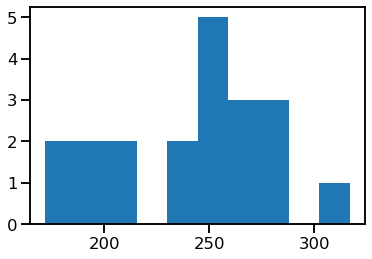

In [39]:
plt.hist(scores)